I am a beginner in kaggle, and i learned much from everyone contributed his/her kernel publicly during in three month ago.  I express my sincere appreciations to all who help me.

This kernel, is just my notebook to summary what I have learned from all kernel publicly about the Titanic compitition. Thanks to** [Erik](https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting), [Chris](https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818/notebook)**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
np.set_printoptions(precision=4)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')
display(train_set.sample(10))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
370,371,1,1,"Harder, Mr. George Achilles",male,25.0,1,0,11765,55.4417,E50,C
702,703,0,3,"Barbara, Miss. Saiide",female,18.0,0,1,2691,14.4542,NaN,C
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.0000,NaN,S
501,502,0,3,"Canavan, Miss. Mary",female,21.0,0,0,364846,7.7500,NaN,Q
163,164,0,3,"Calic, Mr. Jovo",male,17.0,0,0,315093,8.6625,NaN,S
563,564,0,3,"Simmons, Mr. John",male,NaN,0,0,SOTON/OQ 392082,8.0500,NaN,S
359,360,1,3,"Mockler, Miss. Helen Mary ""Ellie""",female,NaN,0,0,330980,7.8792,NaN,Q
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C
547,548,1,2,"Padro y Manent, Mr. Julian",male,NaN,0,0,SC/PARIS 2146,13.8625,NaN,C


In [3]:
print('The shape of train set: {}'.format(train_set.shape))
print('The shape of test set: {}'.format(test_set.shape))

The shape of train set: (891, 12)
The shape of test set: (418, 11)


In [4]:
print(train_set.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [Chris](https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818/notebook) kernel, he point that most of the kernel results tend to predict all male to die  and  all female to survive in the Titanic accident. It should be a gread improvement that to distinguish the survival of the male and the victims of the female. So, he built a "woman-child-groups" feature to actualize his idea.

In [5]:
test_set['Survived'] = np.nan
all_set = pd.concat([train_set,test_set],axis=0,ignore_index=True)

In [6]:
display(all_set['Name'].sample(20))

790                      Keane, Mr. Andrew "Andy"
825                               Flynn, Mr. John
492                    Molson, Mr. Harry Markland
263                         Harrison, Mr. William
1108                     Wick, Mr. George Dennick
552                          O'Brien, Mr. Timothy
1134                           Hyman, Mr. Abraham
758                  Theobald, Mr. Thomas Leonard
501                           Canavan, Miss. Mary
694                               Weir, Col. John
1091                           Murphy, Miss. Nora
202                    Johanson, Mr. Jakob Alfred
218                         Bazzani, Miss. Albina
1297                    Ware, Mr. William Jeffery
262                             Taussig, Mr. Emil
995     Thomas, Mrs. Alexander (Thamine Thelma")"
243                 Maenpaa, Mr. Matti Alexanteri
1214                           Rowe, Mr. Alfred G
922                 Jefferys, Mr. Clifford Thomas
287                          Naidenoff, Mr. Penko


Get the `Surname` and `Title` feature from `Name`

In [7]:
train_set['Surname'] = train_set['Name'].apply(lambda x: str(x).split(',')[0])
train_set['Title'] = train_set['Name'].apply(lambda x: str(x).split('.')[0].split(', ')[1])

In [8]:
display(train_set[['Name','Surname','Title']].sample(10))

,Name,Surname,Title
12,"Saundercock, Mr. William Henry",Saundercock,Mr
621,"Kimball, Mr. Edwin Nelson Jr",Kimball,Mr
380,"Bidois, Miss. Rosalie",Bidois,Miss
323,"Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...",Caldwell,Mrs
70,"Jenkin, Mr. Stephen Curnow",Jenkin,Mr
266,"Panula, Mr. Ernesti Arvid",Panula,Mr
620,"Yasbeck, Mr. Antoni",Yasbeck,Mr
745,"Crosby, Capt. Edward Gifford",Crosby,Capt
576,"Garside, Miss. Ethel",Garside,Miss
246,"Lindahl, Miss. Agda Thorilda Viktoria",Lindahl,Miss


In [9]:
def transform_ticket(x):
    ticket_list = list(x)
    ticket_list[-1] = 'X'
    return ('').join(ticket_list)

In [10]:
train_set['Ticket'] = train_set['Ticket'].apply(transform_ticket)

Tansfrom `Title` to only contain `man`, `woman`, and `boy`

In [11]:
def transform_title(x):
    if x in ["Capt","Don","Major","Col","Rev","Dr","Sir","Mr","Jonkheer"]:
        return 'man'
    elif x in ["Dona","the Countess","Mme","Mlle","Ms","Miss","Lady","Mrs"]:
        return 'woman'
    elif x in ["Master"]:
        return 'boy'

In [12]:
train_set['Title'] = train_set['Title'].apply(transform_title)
display(train_set['Title'].value_counts())

man      538
woman    313
boy       40
Name: Title, dtype: int64

In [13]:
train_set.loc[train_set['Title']=='man','Surname'] = 'noGroup'

In [14]:
def checkTicket(all_data, x):
    re_set = all_data[all_data['Name']!=x['Name']]
    if (x['Title']!='man')&(x['Surname']=='noGroup'):
        if len(re_set.loc[re_set['Ticket']==x['Ticket'],'Surname'])>0:
            return re_set.loc[re_set['Ticket']==x['Ticket'],'Surname'].mode()[0]
        else:
            return x['Surname']
    else:
        return x['Surname']
train_set['Surname'] = train_set.apply(lambda x: checkTicket(train_set,x),axis=1)

### A1 Create the new feature `GroupType`, it means that whether travel with relatives in the Titanic. The passenger that whose `Title` is `man`, their `GroupType` are `noGroup`.

In [15]:
SurnameFreq = train_set['Surname'].value_counts()

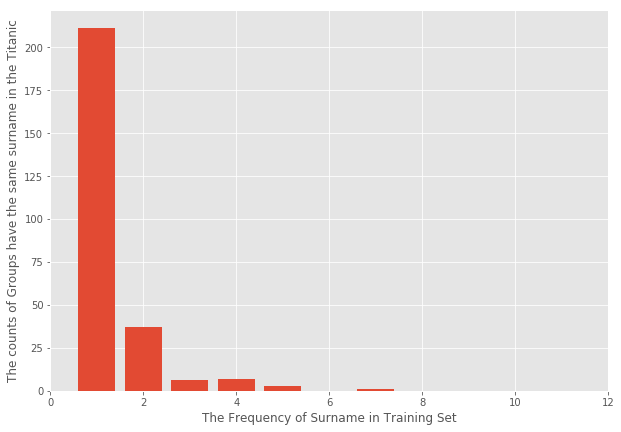

In [16]:
SurnameFreqCounts = SurnameFreq.value_counts()
plt.figure(figsize=(10,7))
plt.bar(SurnameFreqCounts.index,SurnameFreqCounts.values)
plt.xlabel('The Frequency of Surname in Training Set')
plt.xlim([0,12])
plt.ylabel('The counts of Groups have the same surname in the Titanic')
plt.grid(axis=1)
plt.show()

In [17]:
train_set['SurnameFreq'] = train_set['Surname'].apply(lambda x: SurnameFreq[x])
train_set.loc[train_set['SurnameFreq']<=1,'Surname'] = 'noGroup'
SurnameFreq = train_set['Surname'].value_counts()
train_set['SurnameFreq'] = train_set['Surname'].apply(lambda x: SurnameFreq[x])

In [18]:
SurnameSurvival = train_set.groupby('Surname')['Survived'].agg('mean')

In [19]:
display(SurnameSurvival.value_counts().sort_index(ascending=False))

1.000000    34
0.750000     2
0.347130     1
0.333333     1
0.142857     1
0.000000    16
Name: Survived, dtype: int64

In [20]:
train_set['SurnameSurvival'] = train_set['Surname'].apply(lambda x: SurnameSurvival[x])

In [21]:
display(sorted(train_set.loc[train_set['SurnameSurvival']==0,'Surname'].unique()))

['Barbara',
 'Boulos',
 'Bourke',
 'Ford',
 'Goodwin',
 'Jussila',
 'Lefebre',
 'Palsson',
 'Panula',
 'Rice',
 'Sage',
 'Skoog',
 'Strom',
 'Van Impe',
 'Vander Planke',
 'Zabour']

In [22]:
display(sorted(train_set.loc[train_set['SurnameSurvival']==1,'Surname'].unique()))

['Baclini',
 'Becker',
 'Brown',
 'Caldwell',
 'Collyer',
 'Coutts',
 'Doling',
 'Fortune',
 'Goldsmith',
 'Graham',
 'Hamalainen',
 'Harper',
 'Hart',
 'Hays',
 'Herman',
 'Hippach',
 'Johnson',
 'Kelly',
 'Laroche',
 'Mellinger',
 'Moor',
 'Moubarek',
 'Murphy',
 'Navratil',
 'Newell',
 'Nicola-Yarred',
 'Peter',
 'Quick',
 'Richards',
 'Ryerson',
 'Sandstrom',
 'Taussig',
 'West',
 'Wick']

In [23]:
display((train_set.loc[train_set['SurnameSurvival']==1/7,['Surname','Title','Survived']]))

,Surname,Title,Survived
68,Andersson,woman,1
119,Andersson,woman,0
541,Andersson,woman,0
542,Andersson,woman,0
610,Andersson,woman,0
813,Andersson,woman,0
850,Andersson,boy,0


In [24]:
display((train_set.loc[train_set['SurnameSurvival']==1/3,['Surname','Title','Survived']]))

,Surname,Title,Survived
297,Allison,woman,0
305,Allison,boy,1
498,Allison,woman,0


In [25]:
display((train_set.loc[train_set['SurnameSurvival']==3/4,['Surname','Title','Survived']]))

,Surname,Title,Survived
25,Asplund,woman,1
182,Asplund,boy,0
233,Asplund,woman,1
261,Asplund,boy,1
435,Carter,woman,1
763,Carter,woman,1
802,Carter,boy,1
854,Carter,woman,0


In [26]:
train_set['Predict'] = 0
train_set.loc[train_set['Title']=='woman','Predict'] = 1
train_set.loc[(train_set['Title']=='boy')&(train_set['SurnameSurvival']==1),'Predict'] = 1
train_set.loc[(train_set['Title']=='woman')&(train_set['SurnameSurvival']==0),'Predict'] = 0

In [27]:
def Predict_axis(x):
    if x == 1:
        return 0.55+0.4*np.random.rand()
    elif x==0:
        return 0.05+0.4*np.random.rand()

In [28]:
train_set['Predict_axis'] = train_set['Predict'].apply(Predict_axis)

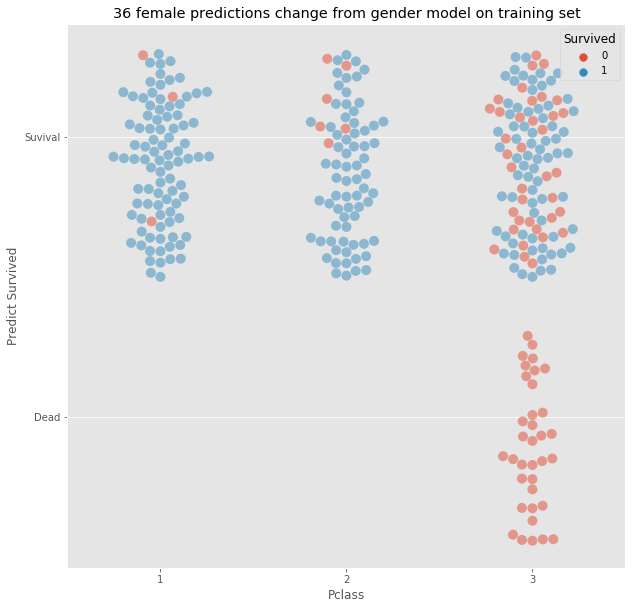

In [29]:
plt.figure(figsize=(10,10))
sns.swarmplot(data=train_set[train_set['Title']=='woman'],x='Pclass',y='Predict_axis',hue='Survived',alpha=0.5,dodge=False,size=10)
plt.yticks([0.3,0.8],['Dead','Suvival'])
plt.xlabel('Pclass')
plt.ylabel('Predict Survived')
plt.title('36 female predictions change from gender model on training set')
plt.show()

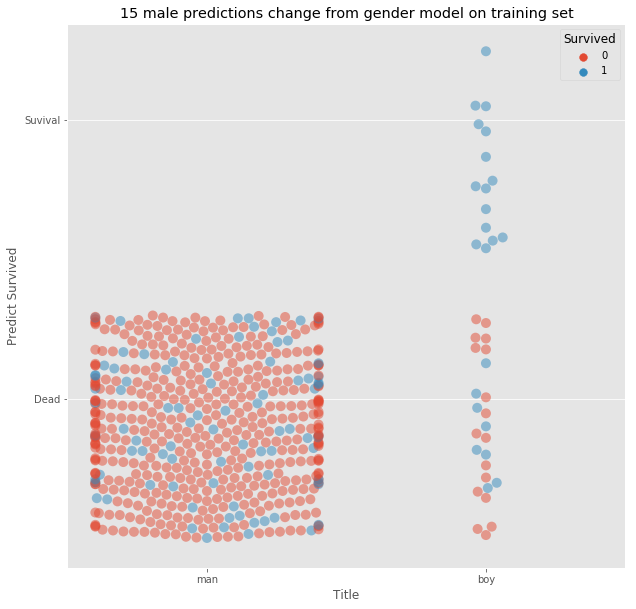

In [30]:
plt.figure(figsize=(10,10))
sns.swarmplot(data=train_set[train_set['Title']!='woman'],x='Title',y='Predict_axis',hue='Survived',alpha=0.5,dodge=False,size=10)
plt.yticks([0.3,0.8],['Dead','Suvival'])
plt.xlabel('Title')
plt.ylabel('Predict Survived')
plt.title('15 male predictions change from gender model on training set')
plt.show()

### Validation operation

In [31]:
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [33]:
all_data = pd.read_csv('data/train.csv')
CV = 10
epochs = 10
for epoch in range(epochs):
    TrainAccuracy = []
    ValidAccuracy = []
    kfold = StratifiedKFold(n_splits=CV,shuffle=True)
    for train_idx,valid_idx in kfold.split(all_data,all_data['Survived']):
        all_data['Title'] = all_data['Name'].apply(lambda x: str(x).split(', ')[1].split('.')[0])
        all_data['Title'] = all_data['Title'].apply(transform_title)

        all_data['Ticket'] = all_data['Ticket'].apply(transform_ticket)

        all_data['Surname'] = all_data['Name'].apply(lambda x: str(x).split(',')[0])
        all_data['Surname'] = all_data.apply(lambda x: checkTicket(train_set,x),axis=1)  
        all_data.loc[all_data['Title']=='man','Surname']= 'noGroup'
        SurnameFreq = all_data['Surname'].value_counts()
        all_data['SurnameFreq'] = all_data['Surname'].apply(lambda x: SurnameFreq[x])
        all_data.loc[all_data['SurnameFreq']<=1,'Surname' ]= 'noGroup'

        SurnameFreq = all_data['Surname'].value_counts()
        all_data['SurnameFreq'] = all_data['Surname'].apply(lambda x: SurnameFreq[x])

        validation = all_data.iloc[valid_idx]['Survived']
        SurnameSurvival = all_data.groupby('Surname')['Survived'].agg('mean')

        all_data['SurnameSurvival'] = all_data['Surname'].apply(lambda x: SurnameSurvival[x])

        all_data['Predict'] = 0
        all_data.loc[all_data['Title']=='woman','Predict'] = 1
        all_data.loc[(all_data['Title']=='boy')&(all_data['SurnameSurvival']==1),'Predict'] = 1
        all_data.loc[(all_data['Title']=='woman')&(all_data['SurnameSurvival']==0),'Predict'] = 0

        train = all_data.iloc[train_idx][['Predict','Survived']]
        valid = all_data.iloc[valid_idx][['Predict','Survived']]

        TrainAccuracy.append(accuracy_score(y_true=train['Survived'],y_pred=train['Predict']))
        ValidAccuracy.append(accuracy_score(y_true=valid['Survived'],y_pred=valid['Predict']))
    print('Trial {} {}-fold Cross-Validation:'.format(epoch+1,CV))
    print('The training accuracy = {:.2f}%(+-{:.2f}%)'.format(np.mean(TrainAccuracy)*100,np.std(TrainAccuracy)*100))
    print('The validation accuracy = {:.2f}%(+-{:.2f}%)'.format(np.mean(ValidAccuracy)*100,np.std(ValidAccuracy)*100))
    print('*'*80)
    print()

Trial 1 10-fold Cross-Validation:
The training accuracy = 84.18%(+-0.33%)
The validation accuracy = 84.18%(+-2.94%)
********************************************************************************

Trial 2 10-fold Cross-Validation:
The training accuracy = 84.18%(+-0.32%)
The validation accuracy = 84.18%(+-2.84%)
********************************************************************************

Trial 3 10-fold Cross-Validation:
The training accuracy = 84.17%(+-0.48%)
The validation accuracy = 84.16%(+-4.40%)
********************************************************************************

Trial 4 10-fold Cross-Validation:
The training accuracy = 84.18%(+-0.61%)
The validation accuracy = 84.17%(+-5.49%)
********************************************************************************

Trial 5 10-fold Cross-Validation:
The training accuracy = 84.18%(+-0.41%)
The validation accuracy = 84.18%(+-3.70%)
********************************************************************************

Trial 6 10

In [ ]:
print('The training accuracy = {:.2f}%(+-{:.2f}%)'.format(np.mean(TrainAccuracy)*100,np.std(TrainAccuracy)*100))
print('The validation accuracy = {:.2f}%(+-{:.2f}%)'.format(np.mean(ValidAccuracy)*100,np.std(ValidAccuracy)*100))

### predict testSet

In [ ]:
trainSet = pd.read_csv('../input/train.csv')
testSet = pd.read_csv('../input/test.csv')
testSet['Survived'] = np.nan
all_data = pd.concat([trainSet,testSet],axis=0,ignore_index=True)


all_data['Title'] = all_data['Name'].apply(lambda x: str(x).split(', ')[1].split('.')[0])
all_data['Title'] = all_data['Title'].apply(transform_title)

all_data['Ticket'] = all_data['Ticket'].apply(transform_ticket)

all_data['Surname'] = all_data['Name'].apply(lambda x: str(x).split(',')[0])
all_data['Surname'] = all_data.apply(lambda x: checkTicket(all_data,x),axis=1)  
all_data.loc[all_data['Title']=='man','Surname']= 'noGroup'
SurnameFreq = all_data['Surname'].value_counts()
all_data['SurnameFreq'] = all_data['Surname'].apply(lambda x: SurnameFreq[x])
all_data.loc[all_data['SurnameFreq']<=1,'Surname' ]= 'noGroup'

SurnameFreq = all_data['Surname'].value_counts()
all_data['SurnameFreq'] = all_data['Surname'].apply(lambda x: SurnameFreq[x])

validation = all_data.iloc[valid_idx]['Survived']
SurnameSurvival = all_data.groupby('Surname')['Survived'].agg('mean')

all_data['SurnameSurvival'] = all_data['Surname'].apply(lambda x: SurnameSurvival[x])

all_data['Predict'] = 0
all_data.loc[all_data['Title']=='woman','Predict'] = 1
all_data.loc[(all_data['Title']=='boy')&(all_data['SurnameSurvival']==1),'Predict'] = 1
all_data.loc[(all_data['Title']=='woman')&(all_data['SurnameSurvival']==0),'Predict'] = 0

### make submission

In [ ]:
testSet = all_data[all_data['Survived'].isna()]
submit = pd.DataFrame({'PassengerId': testSet['PassengerId'],'Survived':testSet['Predict']})
submit.to_csv('genderSurnameModel.csv',index=False)